In [1]:
%pwd 

'/workspaces/OpenDVCW'

In [2]:
# %cd /home/ubu-admin/Developer/tensorflow-wavelets
%cd /workspaces/OpenDVCW
from train import TrainOpenDVCW
import numpy as np
import load
import OpenDVCW
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import optimizers, losses 

import matplotlib.pyplot as plt
import flow_vis
import DataGen
import time
import datetime


/workspaces/OpenDVCW


In [3]:
%load_ext tensorboard

In [4]:
np_folder = "train_set_iqp27.npy"
BATCH_SIZE = 1
EPOCHS = 10
STEPS_PER_EPOCH = 1000
HEIGHT = 240
WIDTH = 240
CHANNLES = 3
NUM_FILTERS = 256
MV_KERNEL_SIZE=3
RES_KERNEL_SIZE=5
M=256
lmbda = 65536
lr_init = 1e-4
lr_alpha = 1e-8
early_stop = 2
I_QP=27
wavelet_name = "haar"
figsize = (20, 20)
template = 'Epoch {}, Loss Wavelet: {}, Loss DVC: {}'

In [5]:
data_gen = DataGen.DataVimeo90kGenerator(np_folder, 
                                            BATCH_SIZE,
                                            (HEIGHT, WIDTH, CHANNLES),
                                            CHANNLES,
                                            True, 
                                            I_QP,
                                            True,
                                            False)

inputs1 = tf.keras.Input(shape=(HEIGHT, WIDTH, CHANNLES,))
inputs2 = tf.keras.Input(shape=(HEIGHT, WIDTH, CHANNLES,))
loss_w, output_w = OpenDVCW.WaveletsOpticalFlow(BATCH_SIZE, HEIGHT, WIDTH,"haar")([inputs1, inputs2])
loss, output = OpenDVCW.OpticalFlow(BATCH_SIZE, HEIGHT, WIDTH)([inputs1, inputs2])

model_w = tf.keras.Model([inputs1, inputs2], [loss_w, output_w])
model = tf.keras.Model([inputs1, inputs2], [loss, output])




2022-12-22 13:32:30.129899: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-22 13:32:30.133285: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-22 13:32:30.133382: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-22 13:32:30.133611: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [6]:

train_loss = tf.keras.metrics.Mean('train_loss', dtype=tf.float32)
train_loss_w = tf.keras.metrics.Mean('train_loss_w', dtype=tf.float32)


current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir_w = 'logs/gradient_tape/' + current_time + '/train_w'
train_log_dir = 'logs/gradient_tape/' + current_time + '/train'
train_w_summary_writer = tf.summary.create_file_writer(train_log_dir_w)
train_summary_writer = tf.summary.create_file_writer(train_log_dir)

In [7]:
model_w.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 240, 240, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 240, 240, 3  0           []                               
                                )]                                                                
                                                                                                  
 wavelets_optical_flow (Wavelet  ((),                240050      ['input_1[0][0]',                
 sOpticalFlow)                   (None, 240, 240, 2               'input_2[0][0]']            

In [8]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 240, 240, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 240, 240, 3  0           []                               
                                )]                                                                
                                                                                                  
 optical_flow (OpticalFlow)     ((),                 240050      ['input_1[0][0]',                
                                 (1, 240, 240, 2))                'input_2[0][0]']          

Epoch 1, Loss Wavelet: 0.0001736570557113737, Loss DVC: 0.0003211054136045277


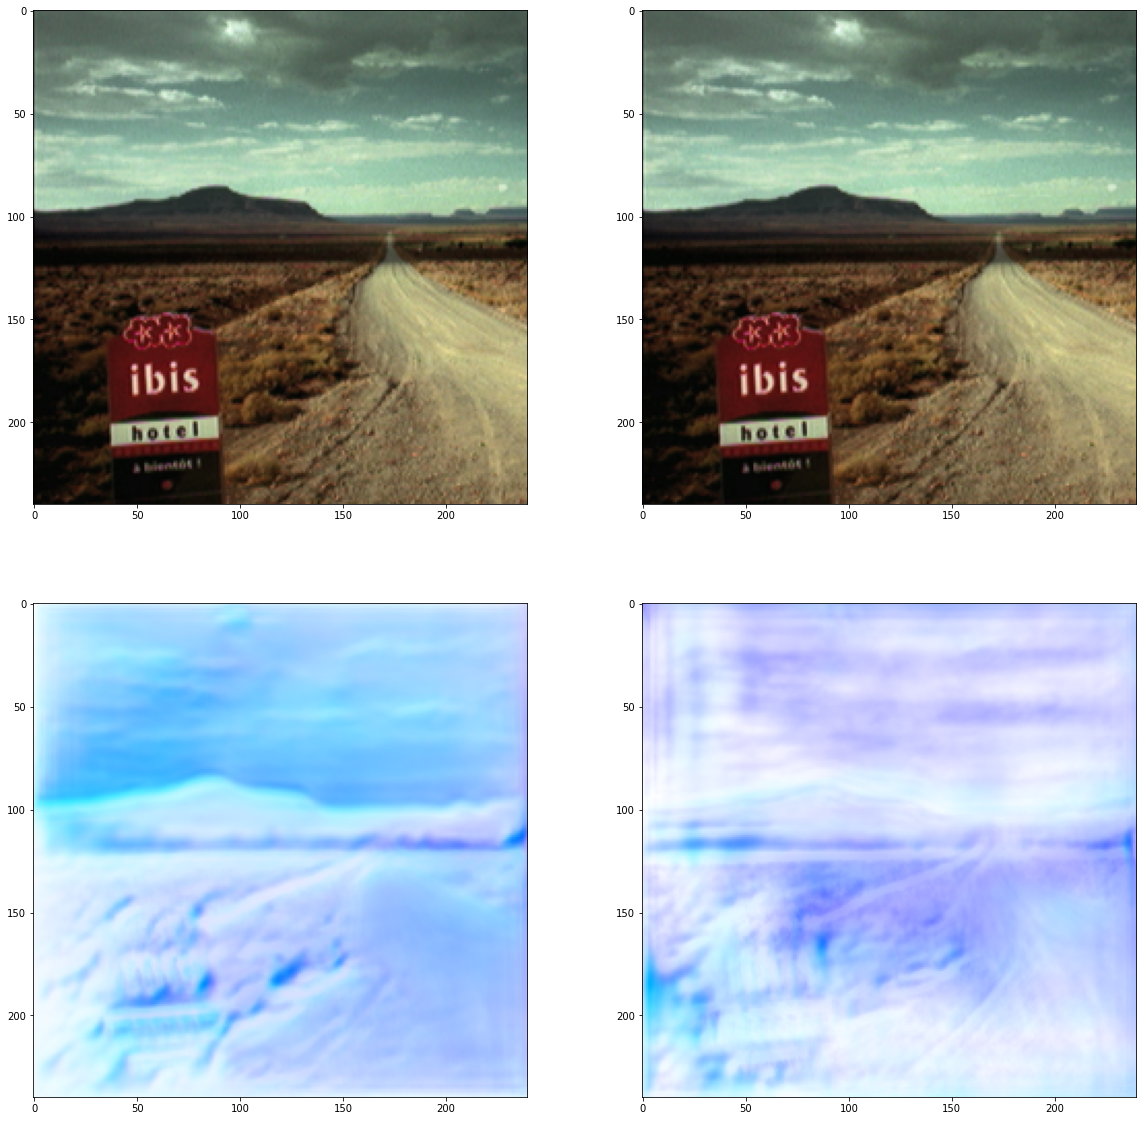

In [9]:
from IPython.display import clear_output

# Instantiate an optimizer.
optimizer_w = tf.keras.optimizers.Adam(learning_rate=lr_init)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_init)
cnt = 0
# Iterate over the batches of a dataset.
for epoch in range(EPOCHS):
    for x, y in data_gen:

        # Open a GradientTape.
        with tf.GradientTape() as tape:
            # Forward pass.
            loss_value, logits = model(x)
            # Loss value for this batch.
        # Get gradients of loss wrt the weights.
        gradients = tape.gradient(loss_value, model.trainable_weights)
        # print(loss_value)
        # Update the weights of the model.
        optimizer.apply_gradients(zip(gradients, model.trainable_weights))
        train_loss(loss_value)
        
        with tf.GradientTape() as tape_w:
            # Forward pass.
            loss_value_w, logits_w = model_w(x)
            # Loss value for this batch.
        # Get gradients of loss wrt the weights.
        gradients_w = tape_w.gradient(loss_value_w, model_w.trainable_weights)
        # print(loss_value)
        # Update the weights of the model.
        optimizer_w.apply_gradients(zip(gradients_w, model_w.trainable_weights))
        train_loss_w(loss_value_w)
        cnt += 1
        if cnt == STEPS_PER_EPOCH:
            cnt = 0
            break
        
    with train_summary_writer.as_default():
        tf.summary.scalar('loss', train_loss.result(), step=epoch)
        
    with train_w_summary_writer.as_default():
        tf.summary.scalar('loss', train_loss_w.result(), step=epoch)
    
        
    clear_output(wait=True)  
    print(template.format(epoch+1,loss_value_w, loss_value))     
    fig, ax = plt.subplots(2,2, figsize=figsize)
    flow = logits
    flow_color = flow_vis.flow_to_color(flow[0], convert_to_bgr=True)
    ax[0,0].imshow(x[0][0])
    ax[0,1].imshow(x[1][0])
    ax[1,0].imshow(flow_color)
    flow_w = logits_w
    flow_color_w = flow_vis.flow_to_color(flow_w[0], convert_to_bgr=True)
    ax[1,1].imshow(flow_color_w)
        
    plt.show()
    